## 0. Setup & Imports

In [1]:

import os, random, math, json, time
from typing import List, Tuple, Dict

import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from tqdm import tqdm

from transformers import AutoImageProcessor, AutoConfig, AutoModelForImageClassification

# Reproducibility
def set_seed(seed: int = 1337):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

# Artifacts dir
ART_DIR = "artifacts"
os.makedirs(ART_DIR, exist_ok=True)


Device: cuda


## 1. Configuration

In [2]:

MODEL_NAMES = [
    "google/vit-base-patch16-224",
    "facebook/deit-base-patch16-224",
    "google/vit-large-patch16-224",
]

# For quick demos, we use CIFAR-10 resized to 224x224.
# Linear probes are trained on a subset for speed; adjust sizes as needed.
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_WORKERS = 2

# Linear probe subset sizes (adjust for more rigorous evaluation)
TRAIN_SAMPLES = 10000  # from CIFAR-10 train (50k total)
TEST_SAMPLES = 2000    # from CIFAR-10 test (10k total)

# Attention visualization: pick a few sample images from the test set
N_VIZ = 6  # number of images to visualize per model

# Patch masking settings
PATCH_SIZE = 16  # for these ViT models, patch16
MASK_KEEP_RATIO_LIST = [1.0, 0.7, 0.4]  # 100% (no mask), 70% kept, 40% kept

# Pooling methods for linear probes
POOLING_METHODS = ["cls", "mean"]

SAVE_JSON = os.path.join(ART_DIR, "task2_summary.json")

print("Config OK")


Config OK


## 2. Dataset (CIFAR-10 resized to 224×224)

In [3]:

# Transforms to 224x224 (models expect 224 with ImageNet normalization handled by processors later)
base_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),  # keep raw [0,1]; processor will normalize
])

train_set = datasets.CIFAR10(root="data", train=True, download=True, transform=base_transform)
test_set  = datasets.CIFAR10(root="data", train=False, download=True, transform=base_transform)

# Subsample for speed
train_indices = np.random.RandomState(42).choice(len(train_set), size=TRAIN_SAMPLES, replace=False)
test_indices  = np.random.RandomState(24).choice(len(test_set),  size=TEST_SAMPLES,  replace=False)

train_subset = Subset(train_set, train_indices)
test_subset  = Subset(test_set,  test_indices)

train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True,  num_workers=NUM_WORKERS, pin_memory=True)
test_loader  = DataLoader(test_subset,  batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

# For visualization picks
viz_indices = np.random.RandomState(7).choice(len(test_set), size=N_VIZ, replace=False)
viz_subset = Subset(test_set, viz_indices)
viz_loader = DataLoader(viz_subset, batch_size=1, shuffle=False)

CIFAR10_CLASSES = train_set.classes
CIFAR10_CLASSES[:5], len(CIFAR10_CLASSES)


100%|██████████| 170M/170M [00:02<00:00, 70.5MB/s]


(['airplane', 'automobile', 'bird', 'cat', 'deer'], 10)

## 3. Utilities — Attention Maps, Heatmap Overlay (Red), Patch Masking, Feature Extraction

In [17]:
import torch.nn as nn
import cv2
import numpy as np

def to_numpy_img(t: torch.Tensor) -> np.ndarray:
    """Convert CHW tensor in [0,1] to HxWxC uint8 for plotting."""
    t = t.detach().cpu().clamp(0,1)
    if t.ndim == 4:
        t = t[0]
    t = (t.permute(1,2,0).numpy() * 255).astype(np.uint8)
    return t

def overlay_red_heatmap(img_np: np.ndarray, heatmap: np.ndarray, alpha: float = 0.45) -> np.ndarray:
    """Overlay a red heatmap onto an image.
    - img_np: HxWxC uint8 image
    - heatmap: HxW float in [0,1]
    - alpha: blending factor
    """
    heatmap = np.clip(heatmap, 0, 1)
    heatmap_uint8 = (heatmap * 255).astype(np.uint8)
    # Use OpenCV applyColorMap with COLORMAP_HOT or build red colormap
    # We'll build a red colormap manually to ensure 'red' hue.
    red_map = np.zeros((256,1,3), dtype=np.uint8)
    red_map[:,0,2] = 0        # Blue
    red_map[:,0,1] = 0        # Green
    red_map[:,0,0] = np.arange(256)  # Red channel increases
    red = cv2.applyColorMap(heatmap_uint8, red_map)  # expects a 256x1x3 LUT

    # Blend
    red = cv2.cvtColor(red, cv2.COLOR_BGR2RGB)
    overlay = cv2.addWeighted(img_np, 1.0, red, alpha, 0)
    return overlay

def attention_to_map(attentions: torch.Tensor, patch_grid: Tuple[int,int]) -> torch.Tensor:
    """Convert last-layer attentions (batch,num_heads,seq,seq) to a [B, H, W] attention map of CLS->patch.
    - attentions: from model outputs.attentions[-1], shape [B, heads, seq, seq]
    - patch_grid: (Gh, Gw), where seq = 1 + Gh*Gw
    Returns: [B, Gh, Gw] averaged over heads.
    """
    B, H, S, _ = attentions.shape
    Gh, Gw = patch_grid
    assert S == 1 + Gh*Gw, f"Seq len mismatch: got {S}, expected {1+Gh*Gw} for grid {patch_grid}"
    # Take CLS token attention to all tokens: index 0 along query dimension
    cls_to_all = attentions.mean(dim=1)[:, 0, :]  # [B, S]
    # Drop the CLS token (first position) -> [B, Gh*Gw]
    cls_to_patches = cls_to_all[:, 1:]
    # Normalize per-sample
    cls_to_patches = cls_to_patches / (cls_to_patches.amax(dim=1, keepdim=True) + 1e-6)
    attn_map = cls_to_patches.reshape(B, Gh, Gw)
    return attn_map

def resize_map_to_img(attn_map: torch.Tensor, img_size: int) -> np.ndarray:
    """Resize [Gh,Gw] attn_map to [img_size,img_size] using cv2."""
    m = attn_map.detach().cpu().numpy()
    m = cv2.resize(m, (img_size, img_size), interpolation=cv2.INTER_CUBIC)
    m = (m - m.min()) / (m.max() - m.min() + 1e-6)
    return m

def mask_image_patches(img_t: torch.Tensor, patch_size: int, keep_ratio: float) -> torch.Tensor:
    """Randomly keep a ratio of patches and zero the rest in the image space.
    - img_t: [C,H,W] in [0,1]
    - patch_size: e.g., 16
    - keep_ratio: in (0,1], fraction of patches to keep
    Returns masked image tensor [C,H,W].
    """
    C, H, W = img_t.shape
    Gh, Gw = H // patch_size, W // patch_size
    total = Gh*Gw
    keep = max(1, int(total * keep_ratio))
    idx = np.random.choice(total, size=keep, replace=False)
    mask = np.zeros(total, dtype=np.uint8)
    mask[idx] = 1
    mask = mask.reshape(Gh, Gw)

    img_np = img_t.detach().cpu().numpy().copy()
    for r in range(Gh):
        for c in range(Gw):
            if mask[r,c] == 0:
                r0, r1 = r*patch_size, (r+1)*patch_size
                c0, c1 = c*patch_size, (c+1)*patch_size
                img_np[:, r0:r1, c0:c1] = 0.0
    return torch.from_numpy(img_np).to(img_t.device)

@torch.no_grad()
def extract_features_batch(model, processor, batch_imgs: torch.Tensor, return_hidden_states: bool = True):
    """Forward pass returning logits and last hidden states for pooling-based features."""
    inputs = processor(images=[to_numpy_img(img) for img in batch_imgs], return_tensors="pt").to(device)
    outputs = model(**inputs, output_attentions=True, output_hidden_states=True)
    logits = outputs.logits
    # For linear probes, we use the last hidden state before classification head
    last_hidden = outputs.hidden_states[-1]  # [B, seq, dim]
    return logits, last_hidden, outputs.attentions # Return all attentions

## 4. Load Models & ImageProcessors

In [15]:
model_zoo = {}
for name in MODEL_NAMES:
    print(f"Loading: {name}")
    processor = AutoImageProcessor.from_pretrained(name)
    # Ensure output_attentions=True is set in the config
    config = AutoConfig.from_pretrained(name)
    config.output_attentions = True
    model = AutoModelForImageClassification.from_pretrained(name, config=config).to(device).eval()
    id2label = model.config.id2label
    model_zoo[name] = {
        "processor": processor,
        "model": model,
        "id2label": id2label,
        "num_labels": model.config.num_labels,
        "patch_grid": (IMG_SIZE // PATCH_SIZE, IMG_SIZE // PATCH_SIZE),
    }
print("Models loaded.")

Loading: google/vit-base-patch16-224


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Loading: facebook/deit-base-patch16-224


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Loading: google/vit-large-patch16-224


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Models loaded.


## 5. Top‑1 Predictions (Sanity Check)

In [9]:

top1_examples = []

for name, pack in model_zoo.items():
    print(f"\n== {name} ==")
    proc, mdl, id2label = pack["processor"], pack["model"], pack["id2label"]
    for i, (img_t, label) in enumerate(viz_loader):
        img_t = img_t.squeeze(0).to(device)  # [C,H,W]
        logits, last_hidden, attn = extract_features_batch(mdl, proc, img_t.unsqueeze(0))
        probs = logits.softmax(dim=-1)[0]
        top1_id = int(probs.argmax().item())
        top1_label = id2label[top1_id]
        conf = float(probs[top1_id].item())
        print(f"Sample {i}: Top-1 -> {top1_label} ({conf:.2f}) | CIFAR10 label: {CIFAR10_CLASSES[label.item()]}")
        top1_examples.append({
            "model": name,
            "sample_idx": i,
            "pred_id": top1_id,
            "pred_label": top1_label,
            "pred_conf": conf,
            "cifar10_label": CIFAR10_CLASSES[label.item()],
        })

# Save to JSON
with open(os.path.join(ART_DIR, "top1_examples.json"), "w") as f:
    json.dump(top1_examples, f, indent=2)
print("Saved:", os.path.join(ART_DIR, "top1_examples.json"))



== google/vit-base-patch16-224 ==
Sample 0: Top-1 -> basset, basset hound (0.26) | CIFAR10 label: dog
Sample 1: Top-1 -> tailed frog, bell toad, ribbed toad, tailed toad, Ascaphus trui (0.98) | CIFAR10 label: frog
Sample 2: Top-1 -> warplane, military plane (0.06) | CIFAR10 label: airplane
Sample 3: Top-1 -> fox squirrel, eastern fox squirrel, Sciurus niger (0.17) | CIFAR10 label: bird
Sample 4: Top-1 -> moving van (0.81) | CIFAR10 label: truck
Sample 5: Top-1 -> ostrich, Struthio camelus (0.98) | CIFAR10 label: bird

== facebook/deit-base-patch16-224 ==
Sample 0: Top-1 -> Shih-Tzu (0.16) | CIFAR10 label: dog
Sample 1: Top-1 -> tailed frog, bell toad, ribbed toad, tailed toad, Ascaphus trui (0.24) | CIFAR10 label: frog
Sample 2: Top-1 -> panpipe, pandean pipe, syrinx (0.04) | CIFAR10 label: airplane
Sample 3: Top-1 -> brambling, Fringilla montifringilla (0.13) | CIFAR10 label: bird
Sample 4: Top-1 -> moving van (0.08) | CIFAR10 label: truck
Sample 5: Top-1 -> ostrich, Struthio camelus

## 6. Attention Visualization — Red Heatmap Overlay

In [10]:

fig_dir = os.path.join(ART_DIR, "attention_overlays")
os.makedirs(fig_dir, exist_ok=True)

for name, pack in model_zoo.items():
    proc, mdl, id2label = pack["processor"], pack["model"], pack["id2label"]
    Gh, Gw = pack["patch_grid"]
    print(f"Generating attention overlays for: {name}")
    for i, (img_t, label) in enumerate(viz_loader):
        img_t = img_t.squeeze(0).to(device)
        logits, last_hidden, attentions = extract_features_batch(mdl, proc, img_t.unsqueeze(0))
        attn_map = attention_to_map(attentions, (Gh, Gw))[0]  # [Gh,Gw]
        attn_big = resize_map_to_img(attn_map, IMG_SIZE)      # [H,W] in [0,1]

        base_img = to_numpy_img(img_t)
        overlay = overlay_red_heatmap(base_img, attn_big, alpha=0.45)

        # Save image
        out_path = os.path.join(fig_dir, f"{name.replace('/','_')}_viz_{i}.png")
        plt.figure(figsize=(4,4))
        plt.axis('off')
        plt.imshow(overlay)
        plt.tight_layout()
        plt.savefig(out_path, dpi=150, bbox_inches='tight')
        plt.close()
print("Saved overlays to:", fig_dir)


Generating attention overlays for: google/vit-base-patch16-224
Generating attention overlays for: facebook/deit-base-patch16-224
Generating attention overlays for: google/vit-large-patch16-224
Saved overlays to: artifacts/attention_overlays


## 7. Patch Masking Experiment — Predictions & Overlays

In [11]:

mask_dir = os.path.join(ART_DIR, "masking_overlays")
os.makedirs(mask_dir, exist_ok=True)

for name, pack in model_zoo.items():
    proc, mdl, id2label = pack["processor"], pack["model"], pack["id2label"]
    Gh, Gw = pack["patch_grid"]
    print(f"Masking for: {name}")
    for i, (img_t, label) in enumerate(viz_loader):
        img_t = img_t.squeeze(0).to(device)
        base_np = to_numpy_img(img_t)

        for keep in MASK_KEEP_RATIO_LIST:
            masked = mask_image_patches(img_t, PATCH_SIZE, keep_ratio=keep)
            logits, last_hidden, attentions = extract_features_batch(mdl, proc, masked.unsqueeze(0))
            probs = logits.softmax(dim=-1)[0]
            top1_id = int(probs.argmax().item())
            top1_label = id2label[top1_id]
            conf = float(probs[top1_id].item())

            attn_map = attention_to_map(attentions, (Gh, Gw))[0]
            attn_big = resize_map_to_img(attn_map, IMG_SIZE)
            overlay = overlay_red_heatmap(to_numpy_img(masked), attn_big, alpha=0.45)

            title = f"{name} | keep={keep:.1f} | pred={top1_label} ({conf:.2f})"
            out_path = os.path.join(mask_dir, f"{name.replace('/','_')}_sample{i}_keep{int(keep*100)}.png")
            plt.figure(figsize=(4,4))
            plt.imshow(overlay)
            plt.title(title, fontsize=8)
            plt.axis('off')
            plt.tight_layout()
            plt.savefig(out_path, dpi=150, bbox_inches='tight')
            plt.close()

print("Saved masking overlays to:", mask_dir)


Masking for: google/vit-base-patch16-224
Masking for: facebook/deit-base-patch16-224
Masking for: google/vit-large-patch16-224
Saved masking overlays to: artifacts/masking_overlays


## 8. Linear Probes — Feature Extraction (CLS vs Mean Pooling)

In [12]:

def pooled_features(last_hidden: torch.Tensor, method: str) -> torch.Tensor:
    # last_hidden: [B, seq, dim]; seq = 1 + Gh*Gw, index 0 is CLS
    if method == "cls":
        feats = last_hidden[:, 0, :]
    elif method == "mean":
        feats = last_hidden[:, 1:, :].mean(dim=1)
    else:
        raise ValueError(f"Unknown pooling: {method}")
    return feats

@torch.no_grad()
def collect_features(model, processor, loader, max_batches=None):
    all_feats = {m: [] for m in POOLING_METHODS}
    all_labels = []
    batches = 0
    for imgs, labels in tqdm(loader, desc="Collecting features"):
        imgs = imgs.to(device)
        logits, last_hidden, _ = extract_features_batch(model, processor, imgs)
        for m in POOLING_METHODS:
            feats = pooled_features(last_hidden, m)
            all_feats[m].append(feats.detach().cpu())
        all_labels.append(labels.detach().cpu())
        batches += 1
        if max_batches is not None and batches >= max_batches:
            break
    all_labels = torch.cat(all_labels).numpy()
    for m in POOLING_METHODS:
        all_feats[m] = torch.cat(all_feats[m]).numpy()
    return all_feats, all_labels

probe_results = {}

for name, pack in model_zoo.items():
    print(f"\nExtracting features for probes: {name}")
    proc, mdl = pack["processor"], pack["model"]
    train_feats, train_labels = collect_features(mdl, proc, train_loader)
    test_feats,  test_labels  = collect_features(mdl, proc, test_loader)

    results = {}
    for m in POOLING_METHODS:
        print(f" Training LogisticRegression for pooling = {m}")
        clf = LogisticRegression(
            max_iter=1000, solver="saga", n_jobs=-1, verbose=0, multi_class="multinomial", C=2.0
        )
        clf.fit(train_feats[m], train_labels)
        pred = clf.predict(test_feats[m])
        acc = accuracy_score(test_labels, pred)
        results[m] = acc
        print(f"  -> Test Acc ({m}): {acc:.4f}")
    probe_results[name] = results

# Save
with open(os.path.join(ART_DIR, "linear_probe_results.json"), "w") as f:
    json.dump(probe_results, f, indent=2)
print(json.dumps(probe_results, indent=2))



Extracting features for probes: google/vit-base-patch16-224


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


 Training LogisticRegression for pooling = cls


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


  -> Test Acc (cls): 0.9620
 Training LogisticRegression for pooling = mean


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


  -> Test Acc (mean): 0.9620

Extracting features for probes: facebook/deit-base-patch16-224


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


 Training LogisticRegression for pooling = cls


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


  -> Test Acc (cls): 0.9075
 Training LogisticRegression for pooling = mean


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


  -> Test Acc (mean): 0.9170

Extracting features for probes: google/vit-large-patch16-224


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


 Training LogisticRegression for pooling = cls


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


  -> Test Acc (cls): 0.9740
 Training LogisticRegression for pooling = mean
  -> Test Acc (mean): 0.9720
{
  "google/vit-base-patch16-224": {
    "cls": 0.962,
    "mean": 0.962
  },
  "facebook/deit-base-patch16-224": {
    "cls": 0.9075,
    "mean": 0.917
  },
  "google/vit-large-patch16-224": {
    "cls": 0.974,
    "mean": 0.972
  }
}


## 9. Accuracy Comparison Plots (Matplotlib)

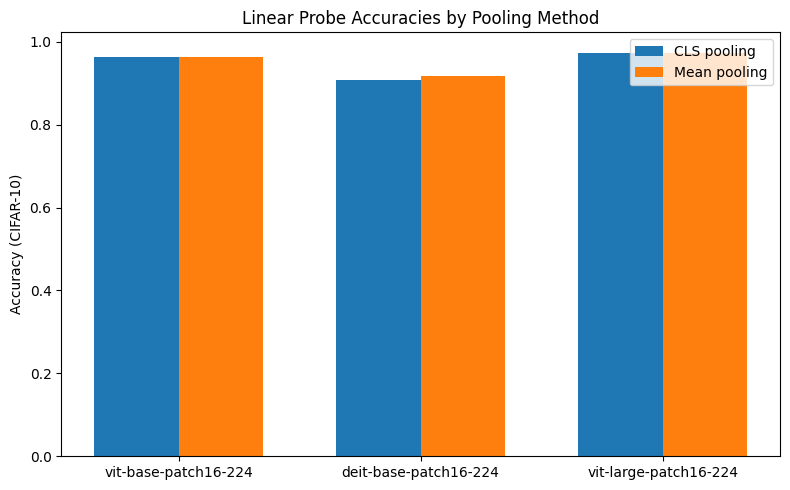

Saved: artifacts/linear_probe_accuracies.png


In [13]:

# Bar plot across models and pooling methods
labels = list(probe_results.keys())
x = np.arange(len(labels))
width = 0.35

cls_acc = [probe_results[k]["cls"]  for k in labels]
mean_acc= [probe_results[k]["mean"] for k in labels]

plt.figure(figsize=(8,5))
plt.bar(x - width/2, cls_acc,  width, label="CLS pooling")
plt.bar(x + width/2, mean_acc, width, label="Mean pooling")
plt.xticks(x, [l.split('/')[-1] for l in labels], rotation=0)
plt.ylabel("Accuracy (CIFAR-10)")
plt.title("Linear Probe Accuracies by Pooling Method")
plt.legend()
plt.tight_layout()
plot_path = os.path.join(ART_DIR, "linear_probe_accuracies.png")
plt.savefig(plot_path, dpi=150)
plt.show()

print("Saved:", plot_path)
